<a href="https://colab.research.google.com/github/rklepov/hse-cs-ml-2018-2019/blob/homework/09-NLP/HW/hw2/nlp_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [*HW_texts*](https://github.com/rklepov/hse-cs-ml-2018-2019/blob/homework/09-NLP/HW/HW_texts.ipynb "HW_texts.ipynb") / –ó–∞–¥–∞–Ω–∏–µ 1

---


In [1]:
!pip install pymorphy2

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [0]:
import os
import pickle

from joblib import Parallel, delayed
from tqdm import tqdm_notebook

In [4]:
import string
import re

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import WhitespaceTokenizer, TweetTokenizer
from nltk.stem.snowball import SnowballStemmer

import pymorphy2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## –ü—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∞

### –ó–∞–≥—Ä—É–∑–∫–∞ –¥–∞–Ω–Ω—ã—Ö —Ç–≤–∏—Ç—Ç–µ—Ä–∞

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
!ls -hl data/

total 2.6G
-rw------- 1 root root  24M Sep 22 12:24 negative.csv
-rw------- 1 root root  26M Sep 22 12:24 positive.csv
-rw------- 1 root root 893M Sep 22 12:24 ria_news_2018.pickle
-rw------- 1 root root 1.2G Sep 22 12:24 ria_vk_comments
-rw------- 1 root root  11M Sep 22 12:24 ria_vk_posts
-rw------- 1 root root  25M Sep 22 12:24 twitter_corpus_lem.dump
-rw------- 1 root root  22M Sep 22 12:24 twitter_corpus_stem.dump
-rw------- 1 root root 472M Sep 22 12:24 vk_comments_corpus_stem.dump


In [7]:
tweets_neg = pd.read_csv('data/negative.csv', sep=';', header=-1)
tweets_pos = pd.read_csv('data/positive.csv', sep=';', header=-1)

tweets = tweets_pos[[3,4]].append(tweets_neg[[3,4]])
tweets.columns = ['text', 'target']
tweets.reset_index(drop=True, inplace=True)
tweets['target'] = tweets['target'].replace({-1:0})

print(tweets.shape)
tweets.head(200).tail(5)

(226834, 2)


text  target
195  RT @olyaolyaTerp: –ö–ª–∞—Å—Å–Ω–æ –ø–æ—Ç–∞–Ω—Ü–µ–≤–∞–ª–∏ —Å–µ–≥–æ–¥–Ω—è ...       1
196  @koortain @veshchij_oleg —è —Ç–∞–∫ –ø–æ–Ω—è–ª, —á—Ç–æ –±—É–¥—É...       1
197  @mindofaddict , —Ä–µ–≥–µ–Ω–µ—Ä–∞—Ü–∏—è –≤ –¥–µ–π—Å—Ç–≤–∏–∏)) –ê–Ω–∞–ª–∏...       1
198  @Yulchik_ya  –º–Ω–µ –≥–æ–≤–æ—Ä–∏–ª–∏, —á—Ç–æ –Ω–∞ —Ç—Ä—É–¥–µ –∑–∞–ª–∏–ª–∏...       1
199  –ü—Ä–æ–≤–æ–¥–∏—Ç—å –≤—Å—Ç—Ä–µ—á–∏ —É—Ç—Ä–æ–º —ç—Ç–æ –ø—Ä–∏–∫–æ–ª—å–Ω–æ ‚Äî –∫–æ–Ω—Ç—Ä–∞...       1

### –û—á–∏—Å—Ç–∫–∞ —Ç–µ–∫—Å—Ç–∞

1.   –£–¥–∞–ª–µ–Ω–∏–µ –ø—É–Ω–∫—Ç—É–∞—Ü–∏–∏
2.   –ü—Ä–∏–≤–µ–¥–µ–Ω–∏–µ –∫ –Ω–∏–∂–Ω–µ–º—É —Ä–µ–≥–∏—Å—Ç—Ä—É
3.   –¢–æ–∫–µ–Ω–∏–∑–∞—Ü–∏—è
4.   –õ–µ–º–º–∞—Ç–∏–∑–∞—Ü–∏—è (–∏–ª–∏ —Å—Ç–µ–º–º–∏–Ω–≥)
5.   –£–¥–∞–ª–µ–Ω–∏–µ —Å—Ç–æ–ø-—Å–ª–æ–≤
6.   –£–¥–∞–ª–µ–Ω–∏–µ –æ—Å—Ç–∞–≤—à–∏—Ö—Å—è —Å–ª–æ–≤ –∏–∑ –æ–¥–Ω–æ–π –±—É–∫–≤—ã
7.   –û–±—Ä–∞—Ç–Ω–æ–µ —Å–æ–µ–¥–∏–Ω–µ–Ω–∏–µ —Ç–æ–∫–µ–Ω–æ–≤ –≤ —Ç–µ–∫—Å—Ç —á–µ—Ä–µ–∑ –ø—Ä–æ–±–µ–ª

–õ–µ–º–º–∞—Ç–∏–∑–∞—Ü–∏—è —Å –ø–æ–º–æ—â—å—é [`pymorphy`](https://pymorphy2.readthedocs.io/en/latest/) –∑–∞–Ω–∏–º–∞–µ—Ç –ø—Ä–æ–¥–æ–ª–∂–∏—Ç–µ–ª—å–Ω–æ–µ –≤—Ä–µ–º—è –ø–æ —Å—Ä–∞–≤–Ω–µ–Ω–∏—é —Å–æ —Å—Ç–µ–º–º–∏–Ω–≥–æ–º. –ü–æ—Å–∫–æ–ª—å–∫—É –ø–æ –∑–∞–¥–∞–Ω–∏—é –≤ –¥–∞–ª—å–Ω–µ–π—à–µ–º –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ –±—É–¥–µ—Ç –ø—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∞—Ç—å –∫–æ—Ä–ø—É—Å –∏–∑ –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤ –í–∫ –æ–±—ä—ë–º–æ–º 4 –º–ª–Ω. —ç–ª–µ–º–µ–Ω—Ç–æ–≤, —Ç–æ —ç—Ç–æ —Å—Ç–∞–Ω–æ–≤—Ç—Å—è –Ω–µ–ø—Ä–∏–µ–º–ª–µ–º–æ. –ö —Ç–æ–º—É –∂–µ, –∫–∞–∫ –ø–æ–∫–∞–∑–∞–ª–∞ –ø—Ä–∞–∫—Ç–∏–∫–∞, –Ω–∞ –¥–∞–Ω–Ω–æ–º –∫–æ—Ä–ø—É—Å–µ –¢–≤–∏—Ç—Ç–µ—Ä–∞ —Å—É—â–µ—Å—Ç–≤–µ–Ω–Ω–æ–≥–æ –ø—Ä–∏—Ä–æ—Å—Ç–∞ –≤ –∫–∞—á–µ—Å—Ç–≤–µ –∑–∞ —Å—á—ë—Ç –ª–µ–º–º–∞—Ç–∏–∑–∞—Ü–∏–∏ –ø–æ —Å—Ä–∞–≤–Ω–µ–Ω–∏—é —Å–æ —Å—Ç–µ–º–º–∏–Ω–≥–æ–º –Ω–µ –Ω–∞–±–ª—é–¥–∞–µ—Ç—Å—è.

In [0]:
def make_punct_remover(pattern = r'[^\w]+'):
    regex = re.compile(pattern)
    return lambda text : regex.sub(' ', text)

def make_lemmatizer(lemmatizer = pymorphy2.MorphAnalyzer()):
    return lambda words : [ lemmatizer.normal_forms(w)[0] for w in words ]

def make_stemmer(stemmer = SnowballStemmer('russian')):
    return lambda words : [ stemmer.stem(w) for w in words ]

In [0]:
def make_prepare_text(punct_remover, tokenizer, lemmatizer, stopwords):
    def prepare_text(text):
        text = punct_remover(text)    
        words = tokenizer.tokenize(text.lower())
        words = lemmatizer(words)
        words = [ w for w in words if len(w) > 1 and w not in stopwords ]
        return ' '.join(words)
    return prepare_text

–ù–µ –±—É–¥–µ–º –≤–∫–ª—é—á–∞—Ç—å —á–∞—Å—Ç–∏—Ü—É *`'–Ω–µ'`* –≤ —Ä—É—Å—Å–∫–∏–π —Å–ø–∏—Å–æ–∫ —Å—Ç–æ–ø-—Å–ª–æ–≤ (–æ–Ω–∞ –º–æ–∂–µ—Ç –≤–ª–∏—è—Ç—å –Ω–∞ —Ç–æ–Ω–∞–ª—å–Ω–æ—Å—Ç—å —Ç–µ–∫—Å—Ç–∞).

In [0]:
stop_words_ru = [ item for item in stopwords.words('russian') if item != '–Ω–µ' ]
stop_words_en = stopwords.words('english') 

stop_words = frozenset(stop_words_ru + stop_words_en)

In [0]:
prepare_text = make_prepare_text(make_punct_remover(), TweetTokenizer(), make_stemmer(), stop_words)

–ü—Ä–∏–º–µ—Ä –ø—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∏ —Ç–µ–∫—Å—Ç–∞:

In [12]:
tweets['text'][15]

'@Jyliaalex —Å–º–æ—Ç—Ä–∏ —Ç–∞–º —Å–ª—É—á–∞–π–Ω–æ –≤ –∞—Å–ø–∏—Ä–∞–Ω—Ç—É—Ä—É –Ω–µ –ø–æ–ø–∞–¥–∏, –Ω–∞—É–∫–∞ –Ω–∏–∫–æ–≥–æ –¥–æ –¥–æ–±—Ä–∞ –Ω–µ –¥–æ–≤–æ–¥–∏–ª–∞)'

In [13]:
prepare_text(tweets['text'][15])

'jyliaalex —Å–º–æ—Ç—Ä —Å–ª—É—á–∞–π–Ω –∞—Å–ø–∏—Ä–∞–Ω—Ç—É—Ä –Ω–µ –ø–æ–ø–∞–¥ –Ω–∞—É–∫ –Ω–∏–∫ –¥–æ–±—Ä –Ω–µ –¥–æ–≤–æ–¥'

### –ü—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∞ –≤—Å–µ–≥–æ –∫–æ—Ä–ø—É—Å–∞ —Ç–µ–∫—Å—Ç–æ–≤

In [0]:
def prepare_corpus(corpus, prepare_text, dump_path):
    if not os.path.exists(dump_path):
        corpus_prep = Parallel(n_jobs=-1)(delayed(prepare_text)(text) for text in tqdm_notebook(corpus))
        with open(dump_path, 'wb') as dump:
            pickle.dump(corpus_prep, dump)
    else:
        with open(dump_path, 'rb') as dump:
            corpus_prep = pickle.load(dump)
    return corpus_prep

twitter_corpus_stem = prepare_corpus(tweets['text'].get_values(), prepare_text, 'data/twitter_corpus_stem.dump')

In [15]:
len(twitter_corpus_stem)

226834

## –ú–æ–¥–µ–ª–∏

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

[–ë–∏–±–ª–∏–æ—Ç–µ–∫–∞ –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏–∏](https://github.com/FUlyankin/hse_texts_do/blob/master/sem_2/visual/ppilif_visual.py "hse_texts_do/ppilif_visual.py at master ¬∑ FUlyankin/hse_texts_do") –æ—Ç –§–∏–ª–∏–ø–ø–∞ `@Ppilif`:

In [0]:
import ppilif_visual as pp

–†–∞–∑–¥–µ–ª–µ–Ω–∏–µ –Ω–∞ –æ–±—É—á–∞—é—â—É—é –∏ —Ç–µ—Å—Ç–æ–≤—É—é –≤—ã–±–æ—Ä–∫–∏.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(twitter_corpus_stem, tweets['target'].get_values(), 
                                                    test_size=0.2, random_state=303)

len(X_train), len(X_test)

(181467, 45367)

### [TF-IDF](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html "sklearn.feature_extraction.text.TfidfVectorizer &#8212; scikit-learn documentation") + [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html "sklearn.linear_model.LogisticRegression &#8212; scikit-learn documentation")

In [0]:
model_tfidf = Pipeline([
            ('vectorizer', TfidfVectorizer(min_df=2, max_df=0.4)),
            ('classifier', LogisticRegression(C=1.))
        ])

model_tfidf.fit(X_train, y_train);

–ü–æ—Ä–æ–≥: 0.4395577152301691
–ü—Ä–∏–Ω—Ü–∏–ø –≤—ã–±–æ—Ä–∞ –ø–æ—Ä–æ–≥–∞: maxf
–ü—Ä–æ—Ü–µ–Ω—Ç–æ–≤ —Ç–µ—Å—Ç–∞ –≤ –±–∞–Ω–µ:  59.05
lift: 1.41 

              precision    recall  f1-score   support

           0       0.79      0.66      0.72     22258
           1       0.72      0.83      0.77     23109

    accuracy                           0.75     45367
   macro avg       0.75      0.74      0.74     45367
weighted avg       0.75      0.75      0.74     45367



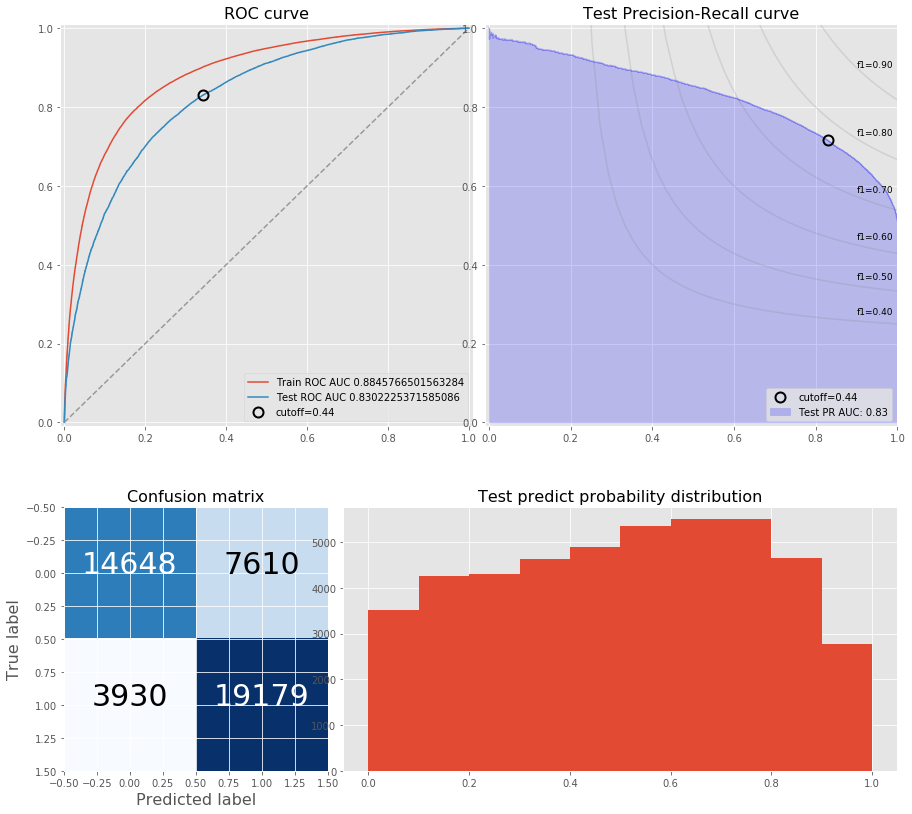

In [20]:
pp.classification_quality_report(model_tfidf, X_train, X_test, y_train, y_test)

### [Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html "sklearn.naive_bayes.MultinomialNB &#8212; scikit-learn documentation")

In [0]:
model_nb = Pipeline([
            ('vectorizer', CountVectorizer()),
            ('classifier', MultinomialNB())
        ])

model_nb.fit(X_train, y_train);

In [22]:
pp.classification_quality_report(model_nb, X_train, X_test, y_train, y_test)

–ü–æ—Ä–æ–≥: 0.2820096952099783
–ü—Ä–∏–Ω—Ü–∏–ø –≤—ã–±–æ—Ä–∞ –ø–æ—Ä–æ–≥–∞: maxf
–ü—Ä–æ—Ü–µ–Ω—Ç–æ–≤ —Ç–µ—Å—Ç–∞ –≤ –±–∞–Ω–µ:  61.55
lift: 1.37 

              precision    recall  f1-score   support

           0       0.79      0.62      0.70     22258
           1       0.70      0.84      0.76     23109

    accuracy                           0.73     45367
   macro avg       0.75      0.73      0.73     45367
weighted avg       0.74      0.73      0.73     45367



### –°—Ä–∞–≤–Ω–µ–Ω–∏–µ

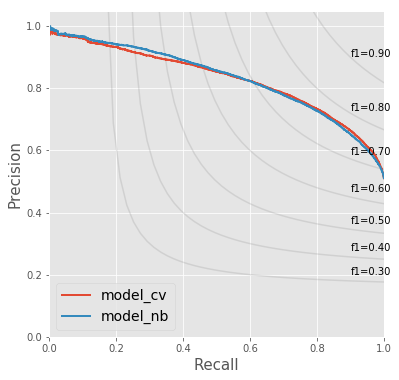

In [23]:
pp.plot_precision_recall_curve_many(
    y_test, figsize=(6 ,6),
    y_pred_probas=[model_tfidf.predict_proba(X_test)[:,-1],
                   model_nb.predict_proba(X_test)[:,-1]],
    labels=['model_cv', 'model_nb'])

## –ö–æ–º–º–µ–Ω—Ç–∞—Ä–∏–∏ –í–ö

In [24]:
with open('data/ria_vk_comments', 'rb') as f:
    vk_comments = pickle.load(f)

vk_comments = pd.DataFrame(vk_comments)

len(vk_comments)

4040551

In [25]:
vk_comments = vk_comments[['post_id', 'text']]

pd.set_option('max_colwidth', 200)

vk_comments.head(100500).tail(5)

post_id                                                                                                             text
100495  23880215                                                        –°–º—ã—Å–ª —Ç–∞–∫–∏—Ö –Ω–æ–≤–æ—Å—Ç–µ–π? –ß–µ—Ä–µ–∑ –º–µ—Å—è—Ü –±—É–¥–µ—Ç –¥—Ä—É–≥–æ–π —Ñ–∞–≤–æ—Ä–∏—Ç...
100496  23880215  –ö–∞–∫–∞—è –≤–æ–æ–±—â–µ –≤ –Ω–∏—Ö —Ä–∞–∑–Ω–∏—Ü–∞, –ª—é–¥–∏ –≤–µ–¥—å —Ç–æ–ª—å–∫–æ –∑–≤–æ–Ω—è—Ç –ø–æ —Ç–µ–ª–µ—Ñ–æ–Ω—É –∏–ª–∏ –í–∞–π–±–µ—Ä—É(–°–∫–∞–π–ø –∏ –¢–î) –∏ –∏–≥—Ä–∞—é—Ç –≤ –∏–≥—Ä—ã –∏ –≤—Å—ë))
100497  23880215                     [id79102026|–ù–∏–∫–∏—Ç–∞], —É—Å—Ç–∞—Ä–µ–ª –¥–∞ , –Ω–æ —É –º–µ–Ω—è –≤—Å–µ –ø–æ —Å–µ–π –¥–µ–Ω—å –≤—Å–µ —Ñ—É–Ω–∫—Ü–∏–æ–Ω–∏—Ä—É–µ—Ç –∏ –≤—Å–µ –¥–æ—Å—Ç—É–ø–Ω–æ
100498  23880215                                                                        [id1022942|–ò–ª—å—è], –∫—É–¥–∞ –Ω–∞ –ª–µ—á–µ–Ω–∏–µ —Å–¥–∞–≤–∞—Ç—å
100499  23880215                                                                   [id134235330|–ü–∞–≤–µ–ª], +79637777080 qiwi –∫–æ—à–µ–ª–µ–∫

In [0]:
vk_comments_corpus_stem = prepare_corpus(vk_comments['text'].get_values(), prepare_text, 'data/vk_comments_corpus_stem.dump')

In [27]:
vk_comments_corpus_stem[:100500][-5:]

['—Å–º—ã—Å–ª –Ω–æ–≤–æ—Å—Ç –º–µ—Å—è—Ü –¥—Ä—É–≥ —Ñ–∞–≤–æ—Ä',
 '–≤–æ–æ–±—â —Ä–∞–∑–Ω–∏—Ü –ª—é–¥ –≤–µ–¥ —Ç–æ–ª—å–∫ –∑–≤–æ–Ω —Ç–µ–ª–µ—Ñ–æ–Ω –∏–ª –≤–∞–π–±–µ—Ä —Å–∫–∞–π–ø —Ç–¥ –∏–≥—Ä–∞ –∏–≥—Ä',
 'id79102026 –Ω–∏–∫–∏—Ç —É—Å—Ç–∞—Ä–µ–ª –º–µ–Ω —Å–µ –¥–µ–Ω —Ñ—É–Ω–∫—Ü–∏–æ–Ω–∏—Ä –¥–æ—Å—Ç—É–ø–Ω',
 'id1022942 –∏–ª –∫—É–¥ –ª–µ—á–µ–Ω —Å–¥–∞–≤–∞',
 'id134235330 –ø–∞–≤–µ–ª 7963777708 qiw –∫–æ—à–µ–ª–µ–∫']

### –¢–æ–ø-10 –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã—Ö –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤ (*Naive Bayes*)

–ü–æ–ø—Ä–æ–±—É–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞—Ç—å —Ç–æ–Ω–∞–ª—å–Ω–æ—Å—Ç—å —Å –ø–æ–º–æ—â—å—é –æ–±—É—á–µ–Ω–Ω–æ–π —Ä–∞–Ω–µ–µ –Ω–∞ –¢–≤–∏—Ç—Ç–µ—Ä–µ –º–æ–¥–µ–ª–∏ *Naive Bayes*.

In [28]:
vk_probas_nb = model_nb.predict_proba(vk_comments_corpus_stem)

vk_probas_nb.shape

(4040551, 2)

–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –¥–ª—è –º–∞–ª–µ–Ω—å–∫–æ–π –¥–µ–º–æ–Ω—Å—Ç—Ä–∞—Ü–∏–æ–Ω–Ω–æ–π –≤—ã–±–æ—Ä–∫–∏ –≤—ã—à–µ:

In [29]:
model_nb.predict(vk_comments_corpus_stem[:100500][-5:])

array([1, 0, 0, 0, 1])

[–ò–Ω–¥–µ–∫—Å—ã](https://stackoverflow.com/a/23734295/10488248 "python - How do I get indices of N maximum values in a NumPy array? - Stack Overflow") 10 –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤ —Å –Ω–∞–∏–±–æ–ª—å—à–µ–π –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω–æ–π –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å—é –∫–ª–∞—Å—Å–∞ 0 (–Ω–µ–≥–∞—Ç–∏–≤):

In [30]:
vk_top10nb_neg_ix = np.argpartition(vk_probas_nb[:,0], -10)[-10:]

vk_top10nb_neg_ix = vk_top10nb_neg_ix[np.argsort(-vk_probas_nb[:,0][vk_top10nb_neg_ix])]

vk_probas_nb[:,0][vk_top10nb_neg_ix]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [31]:
pd.set_option('max_colwidth', 1000)

vk_comments.iloc[vk_top10nb_neg_ix][['text']]

text
2529330  –í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢–ï –¢–ï–õ–ï–ì–£!!!!–í–ï–†–ù–ò–¢...
1176954  [id16817481|–ê–Ω–¥—Ä–µ–π], –ü–æ—Å–ª–µ–¥—Å—Ç–≤–∏—è –±–µ—Ä–µ–º–µ–Ω–Ω–æ—Å—Ç–∏ –∏ —Ä–æ–¥–æ–≤ –¥–ª—è –∂–µ–Ω—â–∏–Ω—ã:\n\n–ü—Ä–æ–±–ª–µ–º—ã —Å –∑—É–±–∞–º–∏  \n–£–≤–µ–ª–∏—á–µ–Ω–∏–µ —Ä–∞–∑–º–µ—Ä–∞ –Ω–æ–≥–∏ 50% –í–æ –≤—Ä–µ–º—è –±–µ—Ä–µ–º–µ–Ω–Ω–æ—Å—Ç–∏ –≤—ã—Ä–∞–±–∞—Ç—ã–≤–∞–µ—Ç—Å—è –≥–æ—Ä–º–æ–Ω —Ä–µ–ª–∞–∫—Å–∏–Ω. –û–Ω –æ—Å–ª–∞–±–ª—è–µ—Ç —Å—É—Å—Ç–∞–≤—ã —Ç–∞–∑–∞, —á—Ç–æ–±—ã —Ä–µ–±–µ–Ω–æ–∫ –º–æ–≥ –ø—Ä–æ–π—Ç–∏ –ø–æ —Ä–æ–¥–æ–≤—ã–º –ø—É—Ç—è–º. –≠—Ç–æ—Ç –≥–æ—Ä–º–æ–Ω —Ç–∞–∫–∂–µ –æ—Å–ª–∞–±–ª—è–µ—Ç –∏ —Å–≤—è–∑–∫–∏ –≤ —Å—Ç—É–ø–Ω—è—Ö, –∏–∑-–∑–∞ —á–µ–≥–æ –∫–æ—Å—Ç–∏ —Å—Ç–æ–ø—ã —Ä–∞—Å—à–∏—Ä—è—é—Ç—Å—è. –°–∞–º–∏ –∫–æ—Å—Ç–∏ –Ω–æ–≥–∏ –Ω–µ —Ä–∞—Å—Ç—É—Ç, –ø—Ä–æ—Å—Ç–æ —Å–≤—è–∑–∫–∏, —É–¥–µ—Ä–∂–∏–≤–∞—é—â–∏–µ 26 –∫–æ—Å—Ç–µ–π —Å—Ç–æ–ø—ã, —Å—Ç–∞–Ω–æ–≤—è—Ç—Å—è –±–æ–ª–µ–µ —Ä–∞—Å—Å–ª–∞–±–ª–µ–Ω–Ω—ã–º–∏.¬†\n\n–í—ã–ø–∞–¥–µ–Ω–∏–µ –≤–æ–ª–æ—Å 50% –ß–∞—â–µ –≤—Å–µ–≥–æ –≤–æ–ª–æ—Å—ã –∞–∫—Ç–∏–≤–Ω–æ –≤—ã–ø–∞–¥–∞—é—Ç –≤ —Ç–µ—á–µ–Ω–∏–µ –ø—Ä–∏–º–µ—Ä–Ω–æ —Ç—Ä–µ—Ö –º–µ—Å—è—Ü–µ–≤ –ø–æ—Å–ª–µ —Ä–æ–¥–æ–≤.  –≤–æ–ª–æ—Å–∞.\n–ë–æ–ª–∏ –≤ —Å–ø–∏–Ω–µ –∏ —Å—É—Å—Ç–∞–≤–∞—Ö 50% –í–æ –≤—Ä–µ–º—è –±–µ—Ä–µ–º–µ–Ω–Ω–æ—Å—Ç–∏ –∏ –ø–æ—Å–ª–µ —Ä–æ–¥–æ–≤ –ø–æ–∑–≤–æ–Ω–æ—á–Ω–∏–∫ –∏—Å–ø—ã—Ç—ã–≤–∞–µ—Ç –≤—Å–µ –±–æ–ª–µ–µ —É–≤–µ–ª–∏—á–∏–≤–∞—é—â–∏–µ—Å—è –Ω–∞–≥—Ä—É–∑–∫–∏. –ü–æ—Å–ª–µ —Ä–æ–¥–æ–≤ –Ω–∞–≥—Ä—É–∑–∫–∏ —ç—Ç–∏ –Ω–∏–∫—É–¥–∞ –Ω–µ –∏—Å—á–µ–∑–∞—é—Ç, –ø–æ–∫–∞ —Ä–µ–±–µ–Ω–æ–∫ –Ω–µ –Ω–∞—É—á–∏—Ç—Å—è —Å–∞–º–æ—Å—Ç–æ—è—Ç–µ–ª—å–Ω–æ —Ö–æ–¥–∏—Ç—å. –ï—Å–ª–∏ –ø–æ–∑–≤–æ–Ω–æ—á–Ω–∏–∫ –æ–∫–∞–∑–∞–ª—Å—è –Ω–µ –≥–æ—Ç–æ–≤ –∫ —Ç–∞–∫–∏–º –Ω–∞–≥—Ä—É–∑–∫–∞–º –≤ –Ω–µ–º –ø—Ä–æ–∏—Å—Ö–æ–¥—è—Ç –Ω–∞—Ä—É—à–µ–Ω–∏—è, –ø—Ä–∏—á–µ–º —á–∞—â–µ –≤—Å–µ–≥–æ —Å—Ç—Ä–∞–¥–∞–µ—Ç –ø–æ—è—Å–Ω–∏—á–Ω—ã–π –æ—Ç–¥–µ–ª.\n–ù–µ–¥–µ—Ä–∂–∞–Ω–∏–µ –º–æ—á–∏ 38,6% —Ä–æ–∂–∞–≤—à–∏—Ö –∂–µ–Ω—â–∏–Ω –ù–µ–ø—Ä–æ–∏–∑–≤–æ–ª—å–Ω–æ–µ –≤—ã–¥–µ–ª–µ–Ω–∏–µ –º–æ—á–∏(–æ—Ç –ø–∞—Ä—ã –∫–∞–ø–µ–ª—å –¥–æ –±–µ—Å–ø—Ä–µ—Ä—ã–≤–Ω–æ–≥–æ –ø–æ–¥—Ç–µ–∫–∞...
2524331  [id375548449|–î–µ–Ω–∏—Å], –¢–¢—Ä–∞—Å—Å–∏—Ä–æ–≤–∫–∞ –º–∞—Ä—à—Ä—É—Ç–∞ –∫ equinix02-iad2.amazon.com [206.126.236.35] \n—Å –º–∞–∫—Å–∏–º–∞–ª—å–Ω—ã–º —á–∏—Å–ª–æ–º –ø—Ä—ã–∂–∫–æ–≤ 30: \n \n 1 2 ms 1 ms <1 –º—Å Dlink-Router.Dlink [192.168.0.1] \n 2 1 ms 2 ms 2 ms 10.92.127.254 \n 3 1 ms 1 ms 1 ms lag-3-438.bgw01.tmn.ertelecom.ru [109.194.168.30] \n 4 * * * –ü—Ä–µ–≤—ã—à–µ–Ω –∏–Ω—Ç–µ—Ä–≤–∞–ª –æ–∂–∏–¥–∞–Ω–∏—è –¥–ª—è –∑–∞–ø—Ä–æ—Å–∞. \n 5 * * * –ü—Ä–µ–≤—ã—à

### –¢–æ–ø-10 –ø–æ–∑–∏—Ç–∏–≤–Ω—ã—Ö –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤ (*Logistic Regression*)

–î–ª—è –∏–Ω—Ç–µ—Ä–µ—Å–∞ —Ç–∞–∫–∂–µ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ —Ç–æ–Ω–∞–ª—å–Ω–æ—Å—Ç–∏ —Å –ø–æ–º–æ—â—å—é –æ–±—É—á–µ–Ω–Ω–æ–π —Ä–∞–Ω–µ–µ –Ω–∞ –¢–≤–∏—Ç—Ç–µ—Ä–µ –ª–æ–≥–∏—Å—Ç–∏—á–µ—Å–∫–æ–π —Ä–µ–≥—Ä–µ—Å—Å–∏–∏.

In [32]:
vk_probas_lr = model_tfidf.predict_proba(vk_comments_corpus_stem)

vk_probas_lr.shape

(4040551, 2)

In [33]:
vk_top10lr_pos_ix = np.argpartition(vk_probas_lr[:,1], -10)[-10:]

vk_top10lr_pos_ix = vk_top10lr_pos_ix[np.argsort(-vk_probas_lr[:,1][vk_top10lr_pos_ix])]

vk_probas_lr[:,1][vk_top10lr_pos_ix]

array([0.99995666, 0.99990503, 0.99950128, 0.99950128, 0.99919412,
       0.99846338, 0.99846338, 0.99846338, 0.99846338, 0.99794689])

In [34]:
list(vk_comments.iloc[vk_top10lr_pos_ix]['text'])

['Dd',
 '–∞—Ö–∞—Ö–∞—Ö,–±–æ—Ä—á:DDD',
 'iisus vosrkese epta :DDD',
 ':DDD',
 '[id109937745|–ò–ª—å—è], :DDD',
 '–ê—Ö–∞—Ö–∞ –±–ª—å–¥ –∞—Ö–∞—Ö–∞—Ö–∞',
 '–ê—Ö–∞—Ö–∞. –ê—Ö–∞—Ö–∞—Ö–∞.',
 '–∞—Ö–∞—Ö–∞ –∞—Ö–∞—Ö–∞—Ö–∞',
 '–ê—Ö–∞—Ö–∞—Ö–∞ –∞—Ö–∞—Ö–∞—Ö',
 '–ê—Ö–∞—Ö–∞ –∞—Ö–∞—Ö–∞—Ö–∞—Ö–∞ –∞—Ö–∞—Ö–∞—Ö']

## –°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –ø–æ –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏—è–º

In [35]:
vk_comments['sentiment'] = np.argmax(vk_probas_nb, axis=1)

vk_comments.head()

post_id  ... sentiment
0  24003681  ...         0
1  24003681  ...         1
2  24003681  ...         1
3  24003681  ...         0
4  24003681  ...         0

[5 rows x 3 columns]

### –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã—Ö –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤

–ü–æ—Å—á–∏—Ç–∞–µ–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã—Ö –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤ –ø–æ –Ω–æ–≤–æ—Å—Ç—è–º.

–ü–æ—Å–∫–æ–ª—å–∫—É –ø–æ–∑–∏—Ç–∏–≤–Ω—ã–π –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–π –∑–∞–∫–æ–¥–∏—Ä–æ–≤–∞–Ω **1**, –∞ –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã–π - **0**, —Ç–æ —á–∏—Å–ª–æ –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã—Ö –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤ –º–æ–∂–Ω–æ –≤—ã—á–∏—Å–ª–∏—Ç—å —Å –ø–æ–º–æ—â—é —Å—Ç–∞–Ω–¥–∞—Ä—Ç–Ω—ã—Ö —Ñ—É–Ω–∫—Ü–∏–π –∞–≥—Ä–µ–≥–∞—Ü–∏–∏:

In [0]:
vk_comments_stats = vk_comments.groupby('post_id')['sentiment'].agg(['count', 'sum'])
vk_comments_stats.columns = [ 'total', 'pos' ]
vk_comments_stats['neg'] = vk_comments_stats['total'] - vk_comments_stats['pos']

In [37]:
vk_comments_stats.head(3)

total  pos  neg
post_id                  
17976037    241  141  100
17976198     51   26   25
17976445    222  132   90

### –¢–æ–ø-5 –Ω–µ–≥–∞—Ç–∏–≤–Ω–æ –≤–æ—Å–ø—Ä–∏–Ω—è—Ç—ã—Ö –Ω–æ–≤–æ—Å—Ç–µ–π

 5 `post_id` –Ω–æ–≤–æ—Å—Ç–µ–π, –∫–æ—Ç–æ—Ä—ã–µ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–∏ –≤–æ—Å–ø—Ä–∏–Ω—è–ª–∏ –Ω–∞–∏–±–æ–ª–µ–µ –æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω–æ (—Å—Ä–µ–¥–∏ —Ç–µ—Ö, –≥–¥–µ –µ—Å—Ç—å —Ö–æ—Ç—è–±—ã 5 –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤).

In [38]:
top_n = 5

topN_neg_comments = vk_comments_stats[vk_comments_stats['total'] > top_n] \
                        .nlargest(top_n, 'neg')

topN_neg_comments

total  pos  neg
post_id                  
21253718   1762  949  813
20204839   1474  706  768
21245320   1312  642  670
20429951   1103  435  668
22759381   1579  920  659

In [39]:
topN_neg_comments.index.to_list()

[21253718, 20204839, 21245320, 20429951, 22759381]

In [40]:
with open('data/ria_vk_posts', 'rb') as f:
    vk_news = pickle.load(f)

vk_news = pd.DataFrame(vk_news)

len(vk_news)

32277

–í—ã–±–µ—Ä–µ–º –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã–µ –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–∏, –¥–æ–±–∞–≤–∏–º –∫–æ–ª–æ–Ω–∫—É —Å URL –ø–æ—Å—Ç–∞ (–µ–≥–æ –º–æ–∂–Ω–æ –≤–æ—Å—Å—Ç–∞–Ω–æ–≤–∏—Ç—å –ø–æ *Id*-—à–Ω–∏–∫–∞–º), —Å–∫–æ–Ω–≤–µ—Ä—Ç–∏—Ä—É–µ–º –≤—Ä–µ–º—è (–∫–æ–ª–æ–Ω–∫–∞ `date`) –≤ —Ñ–æ—Ä–º–∞—Ç `datetime`: 

In [0]:
vk_news_topN_neg = vk_news[vk_news['id'].isin(topN_neg_comments.index.to_list())].copy()

vk_news_topN_neg['url'] = vk_news_topN_neg[['from_id', 'id']] \
    .astype(str) \
    .apply(lambda x: 'https://vk.com/ria?w=wall' + '_'.join(x), axis=1)

vk_news_topN_neg['date'] = pd.to_datetime(vk_news_topN_neg['date'], unit='s')

–ü—Ä–∏—Å–æ–µ–¥–∏–Ω–∏–º —Ç–∞–±–ª–∏—Ü—É —Å –æ—Ü–µ–Ω–∫–æ–π –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤ –ø–æ —Ç–æ–Ω–∞–ª—å–Ω–æ—Å—Ç–∏ –∏ –æ—Ç—Å–æ—Ä—Ç–∏—Ä—É–µ–º –ø–æ —á–∏—Å–ª—É –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã—Ö –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤ (–ø–æ —É–±—ã–≤–∞–Ω–∏—é):

In [42]:
vk_news_topN_neg = vk_news_topN_neg[['id', 'date', 'comments', 'url', 'title', 'text']] \
    .set_index('id') \
    .join(topN_neg_comments.add_prefix('cmt_'), how='inner') \
    .sort_values(['cmt_neg'], ascending=False)

pd.set_option('max_colwidth', 200)

vk_news_topN_neg

date  comments  ... cmt_pos cmt_neg
21253718 2018-06-14 18:12:56      1761  ...     949     813
20204839 2018-03-27 16:24:12      1473  ...     706     768
21245320 2018-06-14 09:53:29      1311  ...     642     670
20429951 2018-04-12 09:31:51      1102  ...     435     668
22759381 2018-10-19 09:17:25      1578  ...     920     659

[5 rows x 8 columns]

–ö–∞–∫ –º–æ–∂–Ω–æ –≤–∏–¥–µ—Ç—å, —á–∏—Å—Ç–æ –∏–Ω—Ç—É–∏—Ç–∏–≤–Ω–æ —Ä–µ–∑—É–ª—å—Ç–∞—Ç –ø–æ–ª—É—á–∏–ª—Å—è –≤–ø–æ–ª–Ω–µ –∞–¥–µ–∫–≤–∞—Ç–Ω—ã–π (—Ç–æ –µ—Å—Ç—å, –≥–ª—è–¥—è –Ω–∞ —ç—Ç–∏ –ø–æ—Å—Ç—ã, –≤–ø–æ–ª–Ω–µ –º–æ–∂–Ω–æ –ø—Ä–µ–¥–ø–æ–ª–æ–∂–∏—Ç—å, —á—Ç–æ –æ–Ω–∏ —Å–æ–±–µ—Ä—É—Ç –º–Ω–æ–≥–æ –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã—Ö –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤).

–ü–æ—Å—Ç—ã, –¥–ª—è –∫–æ—Ç–æ—Ä—ã—Ö –≤ —Ç–∞–±–ª–∏—Ü–µ –≤—ã—à–µ –æ—Ç—Å—É—Ç—Å—Ç–≤—É—é—Ç –∏ –∑–∞–≥–æ–ª–æ–≤–æ–∫, –∏ —Ç–µ–∫—Å—Ç, –º–æ–∂–Ω–æ –ø—Ä–æ–≤–µ—Ä–∏—Ç—å –ø–æ URL (–≤ –≤–∏–¥–µ –≥–∏–ø–µ—Ä—Å—Å—ã–ª–æ–∫ –æ–Ω–∏ –≤—ã–≤–¥–µ–Ω—ã –Ω–∏–∂–µ). 
*–ü—Ä–∏–º–µ—á–∞–Ω–∏–µ*: –≤—Ç–æ—Ä–∞—è —Å—Å—ã–ª–∫–∞ –Ω–µ —Ä–∞–±–æ—Ç–∞–µ—Ç. –í–æ–∑–º–æ–∂–Ω–æ, –ø–æ—Å—Ç –±—ã–ª —É–¥–∞–ª—ë–Ω. –ù–æ –ø–æ –µ–≥–æ –¥–∞—Ç–µ –º–æ–∂–Ω–æ –ø—Ä–µ–¥–ø–æ–ª–æ–∂–∏—Ç—å, —á—Ç–æ –æ–Ω –∏–º–µ–ª –æ—Ç–Ω–æ—à–µ–Ω–∏–µ –∫ –ø–æ–∂–∞—Ä—É –≤ –ö–µ–º–µ—Ä–æ–≤–æ.

In [43]:
vk_news_topN_neg['url']

21253718    https://vk.com/ria?w=wall-15755094_21253718
20204839    https://vk.com/ria?w=wall-15755094_20204839
21245320    https://vk.com/ria?w=wall-15755094_21245320
20429951    https://vk.com/ria?w=wall-15755094_20429951
22759381    https://vk.com/ria?w=wall-15755094_22759381
Name: url, dtype: object

## –ò–Ω–¥–µ–∫—Å –Ω–µ–≥–∞—Ç–∏–≤–∞

In [0]:
search_pattern = '–ø—É—Ç–∏–Ω'
rolling_window = 7

–ù–∞–π–¥—ë–º –≤—Å–µ –ø–æ—Å—Ç—ã, –≤ –∑–∞–≥–æ–ª–æ–≤–∫–µ –∏–ª–∏ —Ç–µ–∫—Å—Ç–µ –∫–æ—Ç–æ—Ä—ã—Ö –µ—Å—Ç—å –∑–∞–¥–∞–Ω–Ω–æ–µ —Å–ª–æ–≤–æ:

In [45]:
def match_news(news_df, search_pattern):
    return news_df['text'].str.lower().str.contains(search_pattern) | \
        news_df['title'].str.lower().str.contains(search_pattern)

vk_news_filtered = vk_news[match_news(vk_news, search_pattern)][['id', 'date', 'title', 'text']].set_index('id')

vk_news_filtered['date'] = pd.to_datetime(vk_news_filtered['date'], unit='s').dt.round(freq='D')

print(f'–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–æ—Å—Ç–æ–≤: {len(vk_news_filtered)}')

vk_news_filtered.head()

–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–æ—Å—Ç–æ–≤: 1381


date  ...                                                                                                                                                                                                     text
id                   ...                                                                                                                                                                                                         
23989576 2019-02-01  ...                                                                                                                      #–ü–†–Ø–ú–ê–Ø–¢–†–ê–ù–°–õ–Ø–¶–ò–Ø \n–í–ª–∞–¥–∏–º–∏—Ä –ü—É—Ç–∏–Ω –Ω–∞ –≤—Å—Ç—Ä–µ—á–µ —Å –ø—Ä–µ–¥—Å—Ç–æ—è—Ç–µ–ª—è–º–∏ –ø—Ä–∞–≤–æ—Å–ª–∞–≤–Ω—ã—Ö —Ü–µ—Ä–∫–≤–µ–π
23976154 2019-01-30  ...                                                                                                                              #–ü–†–Ø–ú–ê–Ø–¢–†–ê–ù–°–õ–Ø–¶–ò–Ø \n–í–ª–∞–¥–∏–º–∏—Ä –ü—É—Ç–∏–Ω –ø—Ä–æ–≤–æ–¥–∏—Ç –≤—Å—Ç—Ä–µ—á—É —Å —á–ª–µ–Ω–∞–º–∏ –ø—Ä–∞–≤–∏—Ç–µ–ª—å—Å—Ç–≤–∞
23967188 2019-01-30  ...  –í–æ –≤—Ä–µ–º—è –ø—Ä–µ–¥–≤—ã–±–æ—Ä–Ω–æ–≥–æ —Ñ–æ—Ä—É–º–∞ –ø—Ä–µ–∑–∏–¥–µ–Ω—Ç–∞ –£–∫—Ä–∞–∏–Ω—ã –ü–µ—Ç—Ä–∞ –ü–æ—Ä–æ—à–µ–Ω–∫–æ –Ω–∞ —ç–∫—Ä–∞–Ω–∞—Ö –ø–æ—è–≤–∏–ª–æ—Å—å –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ —Ä–æ—Å—Å–∏–π—Å–∫–æ–≥–æ –∏ —É–∫—Ä–∞–∏–Ω—Å–∫–æ–≥–æ –ø—Ä–µ–∑–∏–¥–µ–Ω—Ç–æ–≤ —Å –Ω–∞–¥–ø–∏—Å—å—é: "–õ–∏–±–æ –ü–æ—Ä–æ—à–µ–Ω–∫–æ, –ª–∏–±–æ –ü—É—Ç–∏–Ω". \n"–ê –ü—É—Ç–∏–Ω –≤ –∫—É—Ä—Å–µ...
23942168 2019-01-28  ...                                                                                                                                                                                                         
23941178 2019-01-28  ...                                                                                                                                                                                                         

[5 rows x 3 columns]

–ü—Ä–∏—Å–æ–µ–¥–∏–Ω–∏–º —á–∏—Å–ª–æ –ø–æ–ª–æ–∂–∏—Ç–µ–ª—å–Ω—ã—Ö/–æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω—ã—Ö –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤ –¥–ª—è `post_id` –∏ –ø–æ—Å—á–∏—Ç–∞–µ–º —Å–∫–æ–ª—å–∑—è—â–µ–µ —Å—Ä–µ–¥–Ω–µ–µ –¥–ª—è –∑–∞–¥–∞–Ω–Ω–æ–≥–æ –æ–∫–Ω–∞:

In [46]:
def add_rolling_mean(df, col, window):
    df['_'.join([col, 'roll' + str(window)])] = df[col].rolling(window).mean()
    return df

vk_news_neg_idx = vk_news_filtered \
    .join(vk_comments_stats.add_prefix('cmt_'), how='inner') \
    .groupby('date')['cmt_neg', 'cmt_pos'] \
    .sum() \
    .sort_index()

add_rolling_mean(vk_news_neg_idx, 'cmt_neg', rolling_window)
add_rolling_mean(vk_news_neg_idx, 'cmt_pos', rolling_window).tail()

cmt_neg  cmt_pos  cmt_neg_roll7  cmt_pos_roll7
date                                                      
2019-01-25       47       58         119.43         228.43
2019-01-27       71      110          93.57         167.29
2019-01-28      268      436         108.57         184.86
2019-01-30      103      246         114.71         204.14
2019-02-01      110      224         126.57         223.57

–í–∏–∑—É–∞–ª–∏–∑–∏—Ä—É–µ–º –∏–Ω–¥–µ–∫—Å –Ω–µ–≥–∞—Ç–∏–≤–∞:

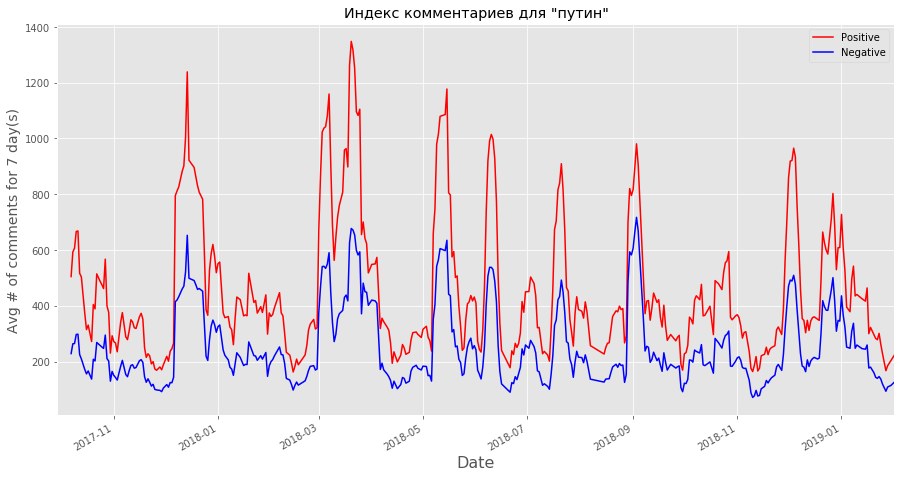

In [47]:
ax = vk_news_neg_idx[['cmt_pos_roll7', 'cmt_neg_roll7']].plot(figsize=(15, 8), color='rb')
ax.set_ylabel(f'Avg # of comments for {rolling_window} day(s)', fontsize=14)
ax.set_xlabel('Date', fontsize=16)
ax.set_title(f'–ò–Ω–¥–µ–∫—Å –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤ –¥–ª—è "{search_pattern}"')
ax.legend(['Positive', 'Negative']);